In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd '/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code'

/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code


In [2]:
!pip install scanpy
!pip install stlearn 
!pip install matplotlib==3.4.3
!pip install preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
import sys 

import os
from copy import deepcopy
import numpy as np
import pandas as pd
import stlearn as st

import torch
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join('../../FPST','code'))
if module_path not in sys.path:
    sys.path.append(module_path)

from load_data import Data, load_visium_data
from train import engine
from image_data import *
from models import NMF
from plot import plot_train_vs_test, plot_genes_read_count, plot_true_vs_reconstructed_histogram
from losses import RMSELossWithoutZeros

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# choose the device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [5]:
# choose the dataset
dataset_name = '../data/Visium_Mouse_Olfactory_Bulb'

## Load data using stlearn

In [6]:
data = st.Read10X(dataset_name)
st.pp.filter_genes(data, min_cells=177)
st.pp.filter_genes(data, min_counts=10)
X = data.X.toarray()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## NMF- random spots

In [ ]:
dataset, data = load_visium_data(dataset_name, min_cells=177, min_counts=10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': 128
}

In [ ]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars
nmf_model = NMF(data.n_vars, data.n_obs, params)

In [ ]:
nmf_execute = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 300,
                    criterion = RMSELossWithoutZeros(),
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_valid,
                    device = device)

NMF(
  (embedding_genes): Embedding(9529, 40)
  (embedding_spots): Embedding(1186, 40)
)


In [ ]:
nmf_train_losses, nmf_test_losses = nmf_execute.execute()

Train epoch 0/300: 100%|██████████| 71449/71449 [04:56<00:00, 241.17it/s]


Epoch #0 Train Loss: 1.152004762276567
Epoch #0 Test Loss: 1.1467583230868297


Train epoch 1/300: 100%|██████████| 71449/71449 [05:03<00:00, 235.07it/s]


Epoch #1 Train Loss: 1.0685443391509701
Epoch #1 Test Loss: 0.9158105930391706


Train epoch 2/300: 100%|██████████| 71449/71449 [05:15<00:00, 226.19it/s]


Epoch #2 Train Loss: 0.9349542463721048
Epoch #2 Test Loss: 0.8191870883190417


Train epoch 3/300: 100%|██████████| 71449/71449 [05:18<00:00, 224.17it/s]


Epoch #3 Train Loss: 0.8595503701889774
Epoch #3 Test Loss: 0.7658401610118761


Train epoch 4/300: 100%|██████████| 71449/71449 [05:23<00:00, 221.18it/s]


Epoch #4 Train Loss: 0.8103149930182715
Epoch #4 Test Loss: 0.7310484155777068


Train epoch 5/300: 100%|██████████| 71449/71449 [05:33<00:00, 214.09it/s]


Epoch #5 Train Loss: 0.774804492689282
Epoch #5 Test Loss: 0.7059266533240882


Train epoch 6/300: 100%|██████████| 71449/71449 [05:36<00:00, 212.52it/s]


Epoch #6 Train Loss: 0.7477666475592044
Epoch #6 Test Loss: 0.6869815957015563


Train epoch 7/300: 100%|██████████| 71449/71449 [05:44<00:00, 207.48it/s]


Epoch #7 Train Loss: 0.7264966124793208
Epoch #7 Test Loss: 0.6721623128772359


Train epoch 8/300: 100%|██████████| 71449/71449 [05:42<00:00, 208.82it/s]


Epoch #8 Train Loss: 0.709285950648102
Epoch #8 Test Loss: 0.6602435668730772


Train epoch 9/300: 100%|██████████| 71449/71449 [05:47<00:00, 205.87it/s]


Epoch #9 Train Loss: 0.6950629965419391
Epoch #9 Test Loss: 0.6504598597895096


Train epoch 10/300: 100%|██████████| 71449/71449 [05:56<00:00, 200.56it/s]


Epoch #10 Train Loss: 0.6831025289589343
Epoch #10 Test Loss: 0.6422794591869408
Early stopping


### Plot train and test vs epochs

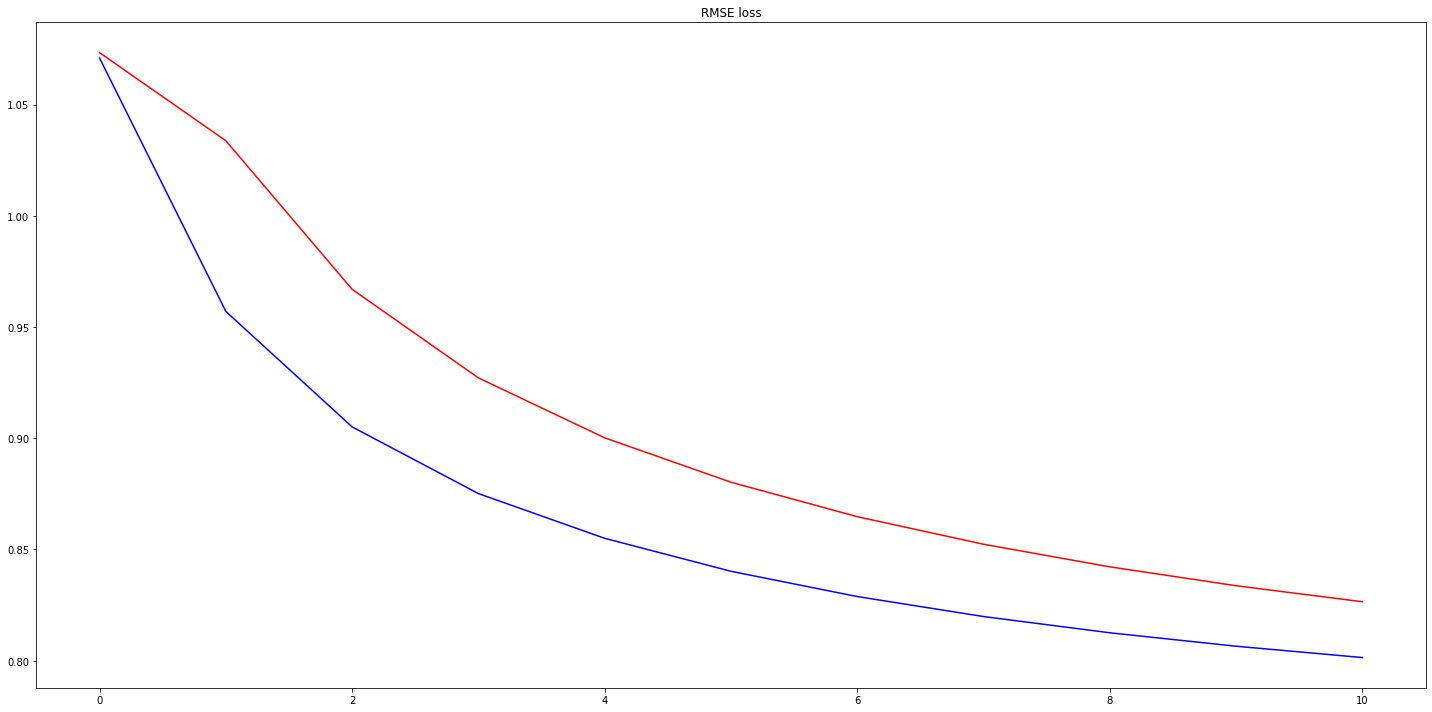

In [ ]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

### Reconstruct data

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nmf_model, dataset, data, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  (0, 3964)	1.0
  (0, 1760)	2.0
  (0, 8731)	1.0
  (0, 2402)	1.0
  (0, 6825)	1.0
  (0, 3744)	1.0
  (0, 3746)	1.0
  (0, 5969)	1.0
  (0, 6350)	1.0
  (0, 1531)	1.0
  (0, 7469)	1.0
  (0, 4043)	1.0
  (0, 7871)	1.0
  (0, 4654)	1.0
  (0, 5184)	1.0
  (0, 3325)	1.0
  (0, 1186)	1.0
  (0, 3164)	1.0
  (0, 3072)	1.0
  (0, 6163)	1.0
  (0, 5250)	1.0
  (0, 4762)	1.0
  (0, 4660)	1.0
  (0, 5647)	1.0
  (0, 5746)	2.0
  :	:
  (1184, 4463)	3.0
  (1184, 7282)	1.0
  (1184, 5687)	11.0
  (1184, 1418)	1.0
  (1184, 6630)	1.0
  (1184, 6555)	2.0
  (1184, 3306)	6.0
  (1184, 6458)	1.0
  (1184, 8425)	24.0
  (1184, 6224)	3.0
  (1184, 3484)	1.0
  (1184, 9521)	196.0
  (1184, 9522)	125.0
  (1184, 9517)	891.0
  (1184, 9518)	499.0
  (1184, 9516)	3.0
  (1184, 9515)	524.0
  (1184, 9519)	682.0
  (1184, 9523)	42.0
  (1184, 9525)	6.0
  (1184, 9524)	260.0
  (1184, 9526)	36.0
  (1184, 9520)	295.0
  (1184, 8952)	1.0
  (1184, 138)	2.0 [[0.37787884 0.37637007 0.35321856 ... 0.73881072 1.43992317 0.37142086]
 [0.87238103 0.77928019 0.7

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Cluster and plot reconstructed data

Normalization step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


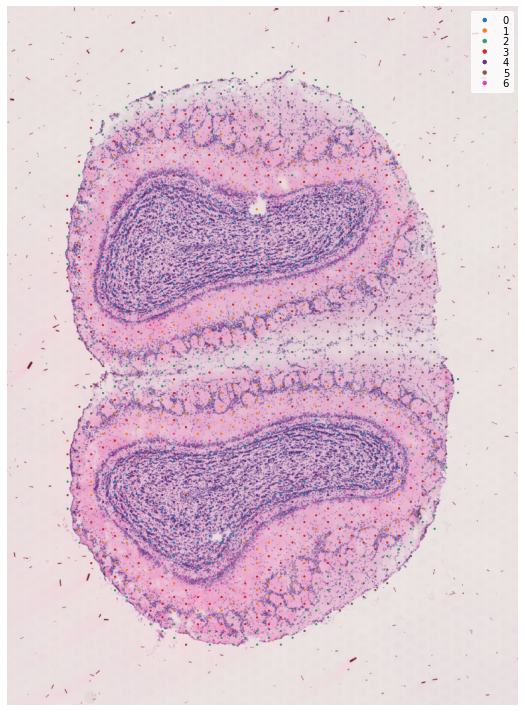

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)

## NMF- data per spot

In [13]:
dataset, data = load_visium_data(dataset_name, 'spots_data', min_cells=177, min_counts=10)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': 128
}

In [15]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars
nmf_model = NMF(number_of_genes, number_of_spots, params)

In [16]:
nmf_execute = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 300,
                    criterion = RMSELossWithoutZeros(),
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_valid,
                    device = device)

NMF(
  (embedding_genes): Embedding(9529, 40)
  (embedding_spots): Embedding(1186, 40)
)


In [17]:
nmf_train_losses, nmf_test_losses = nmf_execute.execute()

Train epoch 0/300: 100%|██████████| 90421/90421 [06:34<00:00, 229.08it/s]


Epoch #0 Train Loss: 1.016254504821904
Epoch #0 Test Loss: 1.106961207580438


Train epoch 1/300: 100%|██████████| 90421/90421 [07:08<00:00, 211.01it/s]


Epoch #1 Train Loss: 0.856635200503463
Epoch #1 Test Loss: 1.1064111090071675


Train epoch 2/300: 100%|██████████| 90421/90421 [07:31<00:00, 200.12it/s]


Epoch #2 Train Loss: 0.7723656077707914
Epoch #2 Test Loss: 1.1060826411198688
Early stopping


### Plot train and test vs epochs

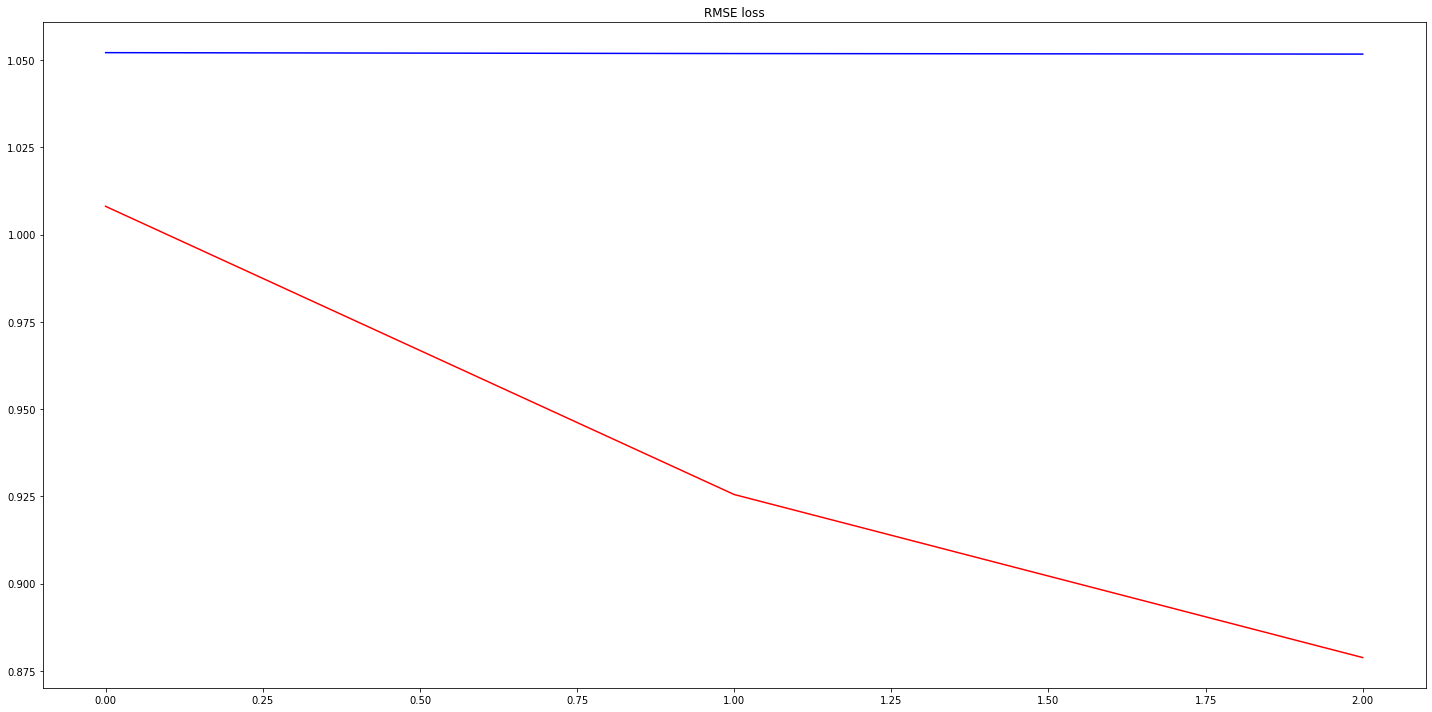

In [18]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

### Reconstruct data

In [19]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nmf_model, dataset, data, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  (0, 3964)	1.0
  (0, 1760)	2.0
  (0, 8731)	1.0
  (0, 2402)	1.0
  (0, 6825)	1.0
  (0, 3744)	1.0
  (0, 3746)	1.0
  (0, 5969)	1.0
  (0, 6350)	1.0
  (0, 1531)	1.0
  (0, 7469)	1.0
  (0, 4043)	1.0
  (0, 7871)	1.0
  (0, 4654)	1.0
  (0, 5184)	1.0
  (0, 3325)	1.0
  (0, 1186)	1.0
  (0, 3164)	1.0
  (0, 3072)	1.0
  (0, 6163)	1.0
  (0, 5250)	1.0
  (0, 4762)	1.0
  (0, 4660)	1.0
  (0, 5647)	1.0
  (0, 5746)	2.0
  :	:
  (1184, 4463)	3.0
  (1184, 7282)	1.0
  (1184, 5687)	11.0
  (1184, 1418)	1.0
  (1184, 6630)	1.0
  (1184, 6555)	2.0
  (1184, 3306)	6.0
  (1184, 6458)	1.0
  (1184, 8425)	24.0
  (1184, 6224)	3.0
  (1184, 3484)	1.0
  (1184, 9521)	196.0
  (1184, 9522)	125.0
  (1184, 9517)	891.0
  (1184, 9518)	499.0
  (1184, 9516)	3.0
  (1184, 9515)	524.0
  (1184, 9519)	682.0
  (1184, 9523)	42.0
  (1184, 9525)	6.0
  (1184, 9524)	260.0
  (1184, 9526)	36.0
  (1184, 9520)	295.0
  (1184, 8952)	1.0
  (1184, 138)	2.0 [[0.41693538 0.55678904 0.36254621 ... 0.83421063 1.64756417 0.45099825]
 [0.98906696 0.89523447 0.9

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Cluster and plot reconstructed data

Normalization step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


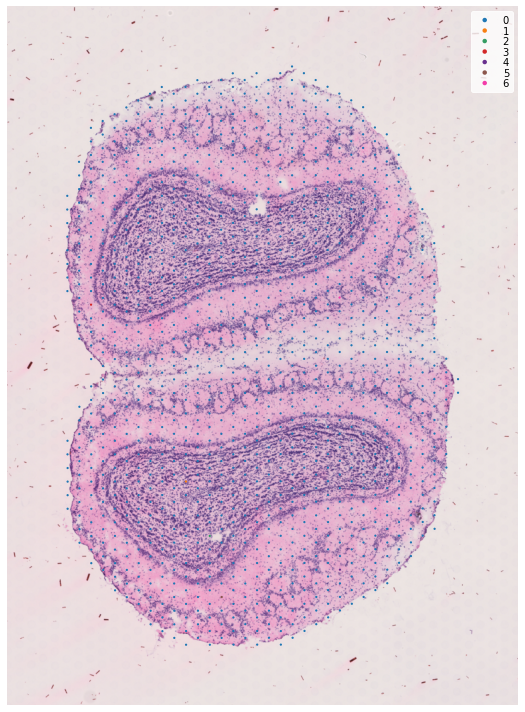

In [20]:
engine.cluster_reconstructed_data(reconstructed_data)

## Train edge detection classifier

In [ ]:
from load_data import load_edge_detection_data
load_edge_detection_data(dataset_name)

(<torch.utils.data.dataloader.DataLoader at 0x7f35810fff70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f35810ff700>)

# NN- MF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NNMF
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 Linear Layer

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "RMSprop",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE,
    'layers_sizes': [(20,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, DEVICE)

In [ ]:
train_nnmf = engine(model = nnmf_model,
                    model_name = 'NNMF',
                    params = params,
                    epochs = 10,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

NNMF(
  (embedding_genes): Embedding(32286, 20)
  (embedding_spots): Embedding(1186, 20)
  (linear_layers): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [ ]:
nnmf_train_losses, nnmf_test_losses = train_nnmf.execute()

Train epoch 0/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.39it/s]


Epoch #0 Train Loss: 1.715077950765421
Epoch #0 Test Loss: 1.1432739220273862


Train epoch 1/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.48it/s]


Epoch #1 Train Loss: 1.4558057859680813
Epoch #1 Test Loss: 1.1426385038114741


Train epoch 2/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 58.66it/s]


Epoch #2 Train Loss: 1.3583749468207718
Epoch #2 Test Loss: 1.1421958867106463


Train epoch 3/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.22it/s]


Epoch #3 Train Loss: 1.3069062600394739
Epoch #3 Test Loss: 1.1418163653589695


Train epoch 4/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.97it/s]


Epoch #4 Train Loss: 1.2750337305282085
Epoch #4 Test Loss: 1.1420464775417325


Train epoch 5/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.69it/s]


Epoch #5 Train Loss: 1.2533327516711268
Epoch #5 Test Loss: 1.1421073479159147


Train epoch 6/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.12it/s]


Epoch #6 Train Loss: 1.2375957593478204
Epoch #6 Test Loss: 1.1420722943277333


Train epoch 7/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.55it/s]


Epoch #7 Train Loss: 1.2256633870287823
Epoch #7 Test Loss: 1.1419659700887672


Train epoch 8/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.43it/s]


Epoch #8 Train Loss: 1.2162969217632982
Epoch #8 Test Loss: 1.1419787936257435


Train epoch 9/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.14it/s]


Epoch #9 Train Loss: 1.2087504861272487
Epoch #9 Test Loss: 1.1419060227512068


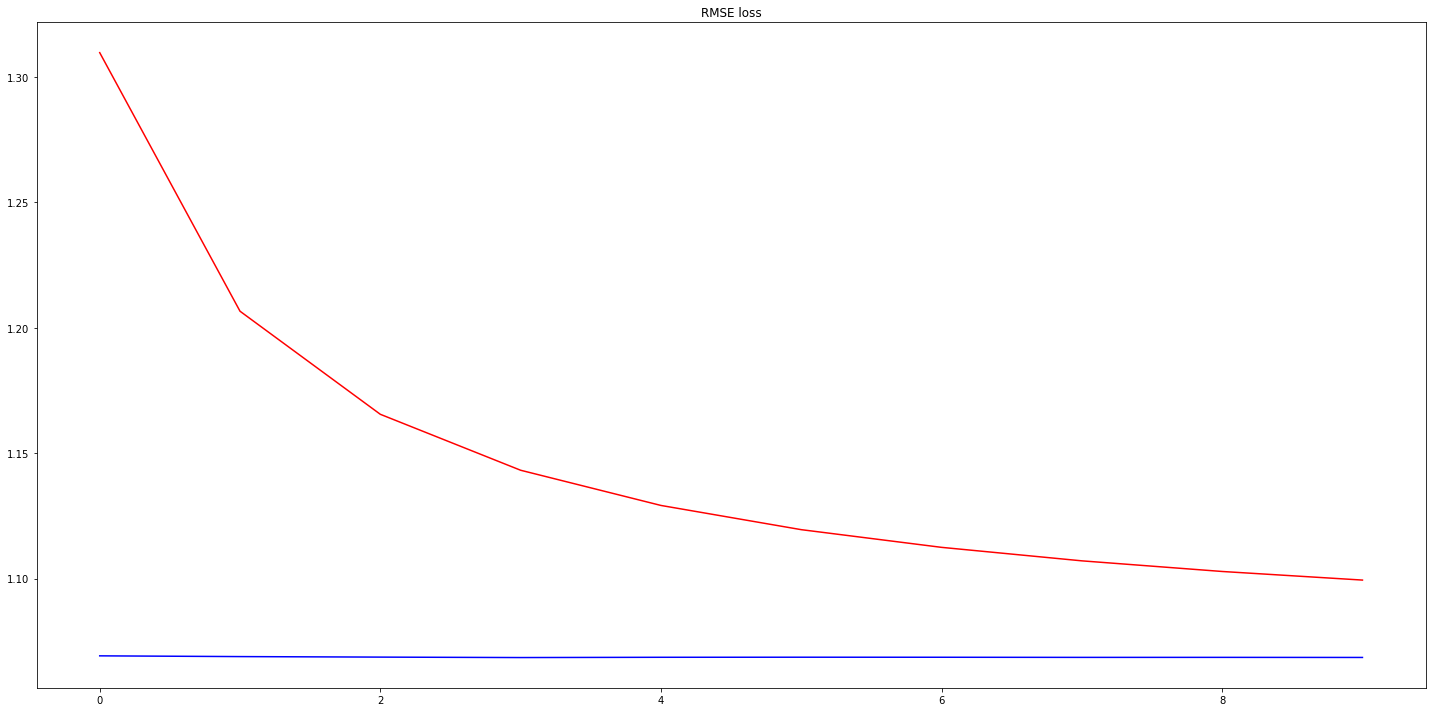

In [ ]:
plot_train_vs_test(nnmf_train_losses, nnmf_test_losses, "RMSE loss")

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nnmf_model, dataset, data, DEVICE)

  (0, 18)	5.0
  (0, 26)	2.0
  (0, 73)	2.0
  (0, 78)	3.0
  (0, 55)	2.0
  (0, 72)	1.0
  (0, 80)	3.0
  (0, 40)	2.0
  (0, 62)	1.0
  (0, 84)	1.0
  (0, 0)	1.0
  (0, 47)	1.0
  (0, 35)	2.0
  (0, 54)	2.0
  (0, 25)	3.0
  (0, 31)	2.0
  (0, 81)	2.0
  (0, 52)	1.0
  (0, 3)	2.0
  (0, 71)	1.0
  (0, 70)	2.0
  (0, 65)	1.0
  (0, 24)	1.0
  (0, 27)	7.0
  (0, 51)	2.0
  :	:
  (1184, 56)	23.0
  (1184, 49)	9.0
  (1184, 36)	15.0
  (1184, 7)	24.0
  (1184, 64)	18.0
  (1184, 9)	17.0
  (1184, 68)	20.0
  (1184, 44)	13.0
  (1184, 5)	13.0
  (1184, 10)	25.0
  (1184, 22)	24.0
  (1184, 16)	32.0
  (1184, 23)	34.0
  (1184, 37)	19.0
  (1184, 85)	24.0
  (1184, 95)	196.0
  (1184, 96)	125.0
  (1184, 91)	891.0
  (1184, 92)	499.0
  (1184, 90)	524.0
  (1184, 93)	682.0
  (1184, 97)	42.0
  (1184, 98)	260.0
  (1184, 99)	36.0
  (1184, 94)	295.0 [[list([3.1679160594940186]) list([3.1769323348999023])
  list([3.1682467460632324]) ... list([3.1713924407958984])
  list([3.18613600730896]) list([3.172372341156006])]
 [list([3.199940681457

ValueError: setting an array element with a sequence.

In [ ]:
plot_true_vs_reconstructed_histogram(df_expressions_true, df_expressions_preds)

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)

## 3 Linear Layers

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE,
    'layers_sizes': [(40,100), (100,50), (50,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, DEVICE)

In [ ]:
train_nnmf = engine(model = nnmf_model,
                    model_name = 'NNMF',
                    params = params,
                    epochs = 10,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

In [ ]:
nnmf_train_losses, nnmf_test_losses = train_nnmf.execute()

In [ ]:
plot_train_vs_test(nnmf_train_losses, nnmf_test_losses, "RMSE loss")

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nnmf_model, dataset, data, DEVICE)

In [ ]:
plot_true_vs_reconstructed_histogram(df_expressions_true, df_expressions_preds)

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)

# NeuMF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NeuMF

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "SGD",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE,
    'layers_sizes': [40, 10]
}

In [ ]:
neumf_model = NeuMF(number_of_genes, number_of_spots, params, DEVICE)

In [ ]:
train_neumf = engine(model = neumf_model,
                    model_name = 'NeuMF',
                    params = params,
                    epochs = 5,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

In [ ]:
neumf_train_losses, neumf_test_losses = train_neumf.execute()

In [ ]:
plot_train_vs_test(neumf_train_losses, neumf_test_losses, "RMSE loss")

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(neumf_model, dataset, data, DEVICE)

In [ ]:
plot_true_vs_reconstructed_histogram(df_expressions_true, df_expressions_preds)

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)